# Chicago Water Lead Levels Anatomization


## Install libraries:

In [2]:
%pip install --upgrade pip
%pip install seaborn
%pip install openpyxl
%pip install python-Levenshtein
%pip install pandas
%pip install numpy
%pip install geopandas
%pip install uszipcode
%pip install altair
%pip install seaborn
%pip install openpyxl
%pip install levenshtein

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Libraries:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
import altair as alt
import json

## Load Dataset:
Load lead data set
Load street data set containing street direction location by Chicago grid address  
Load GeoJson file with Chicago neighborhood boundaries

In [4]:
df = pd.read_excel('lead.xlsx',skiprows=2,dtype={'Address': str, '1st Draw': str, '2/3 Min': str, '5 Min': str})
gdf = chicagogdf = gpd.read_file("boundaries-zipcode.geojson")
df_streets = pd.read_csv('Streets.csv')
zip_df = pd.read_csv('uszips.csv')

Replace X to 0

In [5]:
for i,row in df.iterrows():
    addr = row['Address']
    addr_l = addr.split()
    addr_l[0] = addr_l[0].replace('X','0')
    fixed_addr = ' '.join(addr_l)
    df.loc[i, 'Address'] = fixed_addr
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2019-10-16 00:00:00,100000 S OAKLEY AVE,3,10,9.6
1,2019-02-23 00:00:00,10000 S ARTESIAN AVE,9.2,4.3,2.5
2,2019-05-03 00:00:00,10000 S ARTESIAN AVE,1.1,2.9,1.3
3,2019-05-05 00:00:00,10000 S ARTESIAN AVE,1.2,2.6,< 1
4,2021-11-30 09:00:00,10000 S AVENUE L,3.6,16,4.6
...,...,...,...,...,...
40051,2020-02-19 00:00:00,00 W SCHILLER ST,4.1,3.6,1.2
40052,2020-11-01 00:00:00,00 W SCHILLER ST,< 1,< 1,< 1
40053,2022-10-26 07:04:00,00 W SCHILLER ST,<0.5,<0.5,<0.5
40054,2023-05-23 08:15:00,00 W SCHILLER ST,1,1.3,0.6


Remove invalid row

In [6]:
df = df[df['1st Draw'].notna()]
df = df[df['2/3 Min'].notna()]
df = df[df['5 Min'].notna()]
df = df[df['1st Draw'] != ' ']
df = df[df['5 Min'] != ' ']
df = df[df['2/3 Min'] != ' ']
df = df[df['1st Draw'] != '']
df = df[df['5 Min'] != '']
df = df[df['2/3 Min'] != '']
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2019-10-16 00:00:00,100000 S OAKLEY AVE,3,10,9.6
1,2019-02-23 00:00:00,10000 S ARTESIAN AVE,9.2,4.3,2.5
2,2019-05-03 00:00:00,10000 S ARTESIAN AVE,1.1,2.9,1.3
3,2019-05-05 00:00:00,10000 S ARTESIAN AVE,1.2,2.6,< 1
4,2021-11-30 09:00:00,10000 S AVENUE L,3.6,16,4.6
...,...,...,...,...,...
40051,2020-02-19 00:00:00,00 W SCHILLER ST,4.1,3.6,1.2
40052,2020-11-01 00:00:00,00 W SCHILLER ST,< 1,< 1,< 1
40053,2022-10-26 07:04:00,00 W SCHILLER ST,<0.5,<0.5,<0.5
40054,2023-05-23 08:15:00,00 W SCHILLER ST,1,1.3,0.6


remove '<' symbol

In [7]:
cols = ['1st Draw', '2/3 Min', '5 Min']
df[cols] = df[cols].applymap(lambda x: x.replace('<', '').strip() if isinstance(x, str) else x)
df['1st Draw'] = df['1st Draw'].astype(float)
df['2/3 Min'] = df['2/3 Min'].astype(float)
df['5 Min'] = df['5 Min'].astype(float)
df = df.sort_values('Sample Date', ascending=True).reset_index(drop=True)
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00
...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50


In [8]:
df.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min'], dtype='object')

In [9]:
gdf.columns

Index(['objectid', 'shape_area', 'shape_len', 'zip', 'geometry'], dtype='object')

In [10]:
gdf.head()

,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ..."
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ..."
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ..."
3,36,70853834.3797,42527.9896789,60622,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
4,37,99039621.2518,47970.1401531,60651,"MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ..."


extract address number into a new column. will be used to get coordinates

In [11]:
# Replace 'XX' with '00', then replace 'X' with '0', and extract street numbers
df['Address Num'] = df['Address'].str.replace('XX', '00').str.replace('X', '0').str.extract(r'(\d+)').fillna(0).astype(int)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100
...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700


In [12]:
# Extract the direction (N, S, E, W) from the 'Address' column
df['Address Dir'] = df['Address'].str.extract(r'\s([NSEW])\s')

# If the 'Address Dir' column contains any NaN values, fill them with an empty string
df['Address Dir'].fillna('', inplace=True)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S
...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N


extract street name for joining later on

In [13]:
# Extract the street name from the 'Address' column
df['Street Name'] = df['Address'].str.extract(r'[NSEW]\s(.+)$')
# Remove the asterisk (*) at the end of street names
df['Street Name'] = df['Street Name'].str.replace(r'\*$', '', regex=True)

df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE
...,...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE


add and fill coordinate columns (Lat, Lon)  
if the address direction is N or S, then add the Address Num to Lat  
if the address direction is E or W, then add the Address Num to Lon


In [14]:
# Add 'Lat' column
df['Lat'] = df.apply(lambda row: int(row['Address Num']) if 'N' in row['Address Dir'] or 'S' in row['Address Dir'] else None, axis=1)

# Add 'Lon' column
df['Lon'] = df.apply(lambda row: int(row['Address Num']) if 'E' in row['Address Dir'] or 'W' in row['Address Dir'] else None, axis=1)
df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,NaN
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,NaN
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,NaN
...,...,...,...,...,...,...,...,...,...,...
37313,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,NaN,4900.0
37314,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,NaN
37315,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,NaN
37316,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,NaN


In [15]:
df_streets.columns

Index(['Name', 'Street Dir', 'Street Num'], dtype='object')

In [16]:
df.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min', 'Address Num',
       'Address Dir', 'Street Name', 'Lat', 'Lon'],
      dtype='object')

make sure all street names are upper case before joining

In [17]:
df['Street Name'] = df['Street Name'].str.upper()
df_streets['Name'] = df_streets['Name'].str.upper()



In [18]:
merged_df = pd.merge(df, df_streets, left_on='Street Name', right_on='Name', how='left')


In [19]:
merged_df


,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,NaN,CAMPBELL AVE,W,2500.0
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,NaN,MERRIMAC AVE,W,6234.0
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN,ST LOUIS AVE,W,3500.0
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,NaN,ST LOUIS AVE,W,3500.0
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,NaN,LANGLEY AVE,E,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,NaN,4900.0,KAMERLING AVE,N,1332.0
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,NaN,NOBLE ST,W,1400.0
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,NaN,PAULINA ST,W,1700.0
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,NaN,PARKSIDE AVE,W,5632.0


inspect any rows in the data frame

In [20]:
merged_df.iloc[20000:20010]


,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,NaN,100.0,DELAWARE PL,N,900.0
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,NaN,NEVA AVE,W,7132.0
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,NaN,LARRABEE ST,W,600.0
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,NaN,LUELLA AVE,E,2232.0
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,NaN,3400.0,76TH PL,S,7632.0
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,NaN,NEVA AVE,W,7132.0
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,NaN,3800.0,VAN BUREN ST,S,400.0
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,NaN,3700.0,114TH PL,S,11432.0
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,NaN,5800.0,CORNELIA AVE,N,3500.0
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,NaN,KEYSTONE AVE,W,4032.0


put the street number in the corresponding coordinate (Lat or Lon) 

In [21]:
merged_df['Lat'] = np.where(merged_df['Street Dir'].isin(['N', 'S']), merged_df['Street Num'], merged_df['Lat'])
merged_df['Lon'] = np.where(merged_df['Street Dir'].isin(['E', 'W']), merged_df['Street Num'], merged_df['Lon'])


inspect

In [22]:
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0


In [23]:
merged_df.iloc[20000:20010]

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,900.0,100.0,DELAWARE PL,N,900.0
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,7132.0,NEVA AVE,W,7132.0
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,600.0,LARRABEE ST,W,600.0
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,2232.0,LUELLA AVE,E,2232.0
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,7632.0,3400.0,76TH PL,S,7632.0
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,7132.0,NEVA AVE,W,7132.0
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,400.0,3800.0,VAN BUREN ST,S,400.0
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,11432.0,3700.0,114TH PL,S,11432.0
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,3500.0,5800.0,CORNELIA AVE,N,3500.0
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,4032.0,KEYSTONE AVE,W,4032.0


we now have the city grid locations. we need to convert to gps coordinates  

In [24]:
base_lat = 41.8820500120278
base_lon = -87.62782737167875
# lat_factor = 0.0000174041
# lon_factor = 0.0000248416
lat_factor_N = 0.00001818932
lat_factor_S = 0.00001687716
lon_factor_E = 0.00002430679
lon_factor_W = 0.00002456658

# Create 'Lat GPS' column with computed values
merged_df['Lat GPS'] = np.where(
    (merged_df['Street Dir'].isin(['N']) | merged_df['Address Dir'].isin(['N'])),
    base_lat + merged_df['Lat'] * lat_factor_N, merged_df['Lat']
)
merged_df['Lat GPS'] = np.where(
    (merged_df['Street Dir'].isin(['S']) | merged_df['Address Dir'].isin(['S'])),
    base_lat - merged_df['Lat'] * lat_factor_S, merged_df['Lat GPS']
)

# Create 'Lon GPS' column with computed values
merged_df['Lon GPS'] = np.where(
    (merged_df['Street Dir'].isin(['E']) | merged_df['Address Dir'].isin(['E'])),
    base_lon + merged_df['Lon'] * lon_factor_E, merged_df['Lon']
)
merged_df['Lon GPS'] = np.where(
    (merged_df['Street Dir'].isin(['W']) | merged_df['Address Dir'].isin(['W'])),
    base_lon - merged_df['Lon'] * lon_factor_W, merged_df['Lon GPS']
)



In [25]:
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186


In [26]:
merged_df.iloc[20000:20010]

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS
20000,2019-11-19,100 E DELAWARE PL,1.0,1.0,1.0,100,E,DELAWARE PL,900.0,100.0,DELAWARE PL,N,900.0,41.898420,-87.625397
20001,2019-11-19,1900 N NEVA AVE,1.0,1.0,1.0,1900,N,NEVA AVE,1900.0,7132.0,NEVA AVE,W,7132.0,41.916610,-87.803036
20002,2019-11-19,2000 N LARRABEE ST,1.9,1.9,1.0,2000,N,LARRABEE ST,2000.0,600.0,LARRABEE ST,W,600.0,41.918429,-87.642567
20003,2019-11-19,8400 S LUELLA AVE,1.7,1.1,1.0,8400,S,LUELLA AVE,8400.0,2232.0,LUELLA AVE,E,2232.0,41.740282,-87.573575
20004,2019-11-19,3400 W 76TH PL,4.1,1.5,1.2,3400,W,76TH PL,7632.0,3400.0,76TH PL,S,7632.0,41.753244,-87.711354
20005,2019-11-19,5900 N NEVA AVE,2.0,1.1,1.1,5900,N,NEVA AVE,5900.0,7132.0,NEVA AVE,W,7132.0,41.989367,-87.803036
20006,2019-11-19,3800 W VAN BUREN ST,1.8,4.2,2.7,3800,W,VAN BUREN ST,400.0,3800.0,VAN BUREN ST,S,400.0,41.875299,-87.721180
20007,2019-11-19,3700 W 114TH PL,14.0,2.7,2.9,3700,W,114TH PL,11432.0,3700.0,114TH PL,S,11432.0,41.689110,-87.718724
20008,2019-11-19,5800 W CORNELIA AVE,1.6,2.0,2.6,5800,W,CORNELIA AVE,3500.0,5800.0,CORNELIA AVE,N,3500.0,41.945713,-87.770314
20009,2019-11-19,900 N KEYSTONE AVE,1.0,1.0,1.0,900,N,KEYSTONE AVE,900.0,4032.0,KEYSTONE AVE,W,4032.0,41.898420,-87.726880


In [27]:
gdf.columns

Index(['objectid', 'shape_area', 'shape_len', 'zip', 'geometry'], dtype='object')

the dataset is now ready to be plotted on the geojson shape file

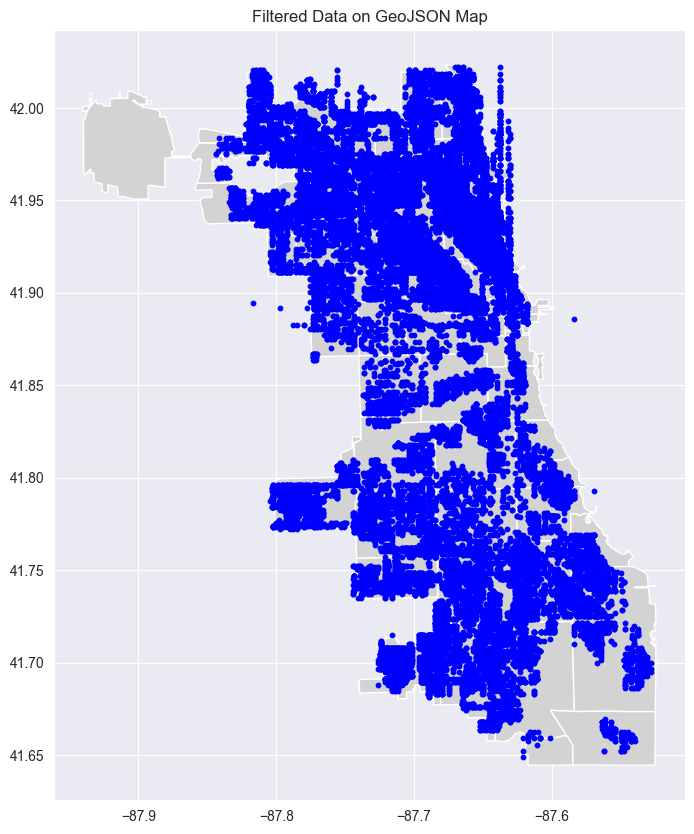

In [28]:
# Define your bounding box (min_lon, min_lat, max_lon, max_lat)
bounding_box = (-87.90, 41.50, -87.50, 42.08)  # Example bounding box

# Filter the DataFrame to include only points within the bounding box
filtered_df = merged_df[
    (merged_df['Lon GPS'] >= bounding_box[0]) &
    (merged_df['Lon GPS'] <= bounding_box[2]) &
    (merged_df['Lat GPS'] >= bounding_box[1]) &
    (merged_df['Lat GPS'] <= bounding_box[3])
]

# Create a GeoDataFrame from the filtered DataFrame
gdf = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(filtered_df['Lon GPS'], filtered_df['Lat GPS']),
    crs="EPSG:4326"
)

# Read the GeoJSON file into a GeoDataFrame
geojson_file = "boundaries-zipcode.geojson"
geojson_gdf = gpd.read_file(geojson_file)

# Plot the GeoJSON data and the filtered points
ax = geojson_gdf.plot(color='lightgray', figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=10)

# You can customize the plot further if needed
plt.title("Filtered Data on GeoJSON Map")
plt.show()

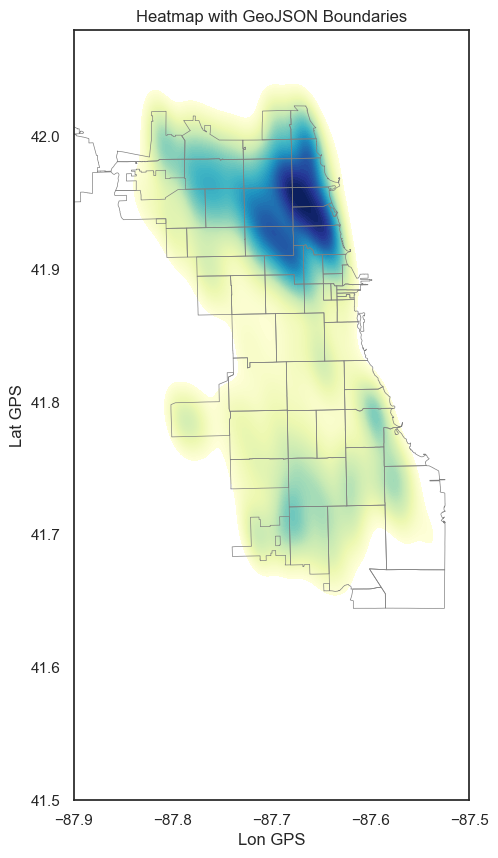

In [29]:

# Define your bounding box (min_lon, min_lat, max_lon, max_lat)
bounding_box = (-87.90, 41.50, -87.50, 42.08)  # Example bounding box

# Filter the DataFrame to include only points within the bounding box
filtered_df = merged_df[
    (merged_df['Lon GPS'] >= bounding_box[0]) &
    (merged_df['Lon GPS'] <= bounding_box[2]) &
    (merged_df['Lat GPS'] >= bounding_box[1]) &
    (merged_df['Lat GPS'] <= bounding_box[3])
]

# Create a GeoDataFrame from the filtered DataFrame
gdf = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(filtered_df['Lon GPS'], filtered_df['Lat GPS']),
    crs="EPSG:4326"
)

# Create a heatmap
sns.set(style="white")
plt.figure(figsize=(10, 10))
sns.kdeplot(data=gdf, x="Lon GPS", y="Lat GPS", fill=True, cmap="YlGnBu", levels=100)

# Read the GeoJSON file into a GeoDataFrame
geojson_file = "boundaries-zipcode.geojson"
geojson_gdf = gpd.read_file(geojson_file)

# Plot the GeoJSON data on top of the heatmap
ax = geojson_gdf.plot(ax=plt.gca(), color='none', edgecolor='gray', linewidth=0.5)
ax.set_xlim(bounding_box[0], bounding_box[2])
ax.set_ylim(bounding_box[1], bounding_box[3])

plt.title("Heatmap with GeoJSON Boundaries")
plt.show()

In [30]:
gdf.columns

Index(['Sample Date', 'Address', '1st Draw', '2/3 Min', '5 Min', 'Address Num',
       'Address Dir', 'Street Name', 'Lat', 'Lon', 'Name', 'Street Dir',
       'Street Num', 'Lat GPS', 'Lon GPS', 'geometry'],
      dtype='object')

In [31]:
search = SearchEngine(db_file_path="./tmp/zipcodes.sqlite") 

In [32]:
def get_zip_code(latitude, longitude):
    '''This function turns Latitude and Longitude into zipcodes'''
    #print(latitude,longitude)
    try:
        z = search.by_coordinates(lat = latitude,lng =  longitude, radius = 5, returns = 1)
        return z[0].to_dict()['zipcode']
    except:
        z = "error"
        return z
     #access the zipcode from information object


#Add zipcode column to cameras_sorted 
#this will take like 5 mins to run make sure you have python levenshtein installed https://pypi.org/project/python-Levenshtein/
merged_df['zip'] = merged_df.apply(lambda datapoint: get_zip_code(datapoint['Lat GPS'],datapoint['Lon GPS']), axis = 1)
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS,zip
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244,60609
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975,60706
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813,60637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204,60651
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221,60642
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591,60622
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186,60639


In [33]:
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS,zip
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244,60609
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975,60706
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813,60637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204,60651
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221,60642
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591,60622
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186,60639


In [34]:
#Aggregate data by averaging by neighborhood
draws_by_zip = merged_df.groupby('zip')['1st Draw', '2/3 Min', '5 Min'].mean().reset_index()
draws_by_zip

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [ ]:
gdf_merged_avg_draws = pd.merge(draws_by_zip, gdf, how='inner', on='zip')
gdf_merged_avg_draws = gpd.GeoDataFrame(gdf_merged_avg_draws, crs="EPSG:4326", geometry='geometry')


In [ ]:
#makes choropleth maps
def gen_map(geodata, color_column, title, tooltip, color_scheme='bluegreen'):
    '''
    Generates chicago neighbourhoods map with choropleth
    '''
    
    # Add Base Layer
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=800,
        height=800
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
        stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme=color_scheme),
                  title = ""),
         tooltip=tooltip
    
    return base + choro

In [ ]:
choro_avg_draws_json = json.loads(gdf_merged_avg_draws.to_json()) #to json
choro_avg_draws_data = alt.Data(values=choro_avg_draws_json['features']) #altair data
avg_1st_choro_map = gen_map(geodata=choro_avg_draws_data, color_column='properties.1st Draw', title='average 1st draw by zip', tooltip=['properties.zip:N','properties.1st Draw:Q'])
avg_1st_choro_map

In [ ]:
avg_2min_choro_map = gen_map(geodata=choro_avg_draws_data, color_column='properties.2/3 Min', title='average lead after 2-3 min by zip', tooltip=['properties.zip:N','properties.1st Draw:Q'])
avg_2min_choro_map

In [ ]:
avg_5min_choro_map = gen_map(geodata=choro_avg_draws_data, color_column='properties.5 Min', title='average lead after 5 mins running', tooltip=['properties.zip:N','properties.1st Draw:Q'])
avg_5min_choro_map

In [ ]:
all_draws_avg_map_linked = avg_1st_choro_map | avg_2min_choro_map | avg_5min_choro_map
all_draws_avg_map_linked

# Zip Code EDA Columns info in progress report

In [57]:
merged_df = merged_df[merged_df['zip'].astype(str) != 'error']
merged_df

,Sample Date,Address,1st Draw,2/3 Min,5 Min,Address Num,Address Dir,Street Name,Lat,Lon,Name,Street Dir,Street Num,Lat GPS,Lon GPS,zip
0,2016-01-27 00:00:00,3800 S CAMPBELL AVE,1.54,1.00,1.00,3800,S,CAMPBELL AVE,3800.0,2500.0,CAMPBELL AVE,W,2500.0,41.817917,-87.689244,60609
1,2016-01-27 00:00:00,4500 N MERRIMAC AVE,3.22,2.17,1.94,4500,N,MERRIMAC AVE,4500.0,6234.0,MERRIMAC AVE,W,6234.0,41.963902,-87.780975,60706
2,2016-01-29 00:00:00,2500 N ST LOUIS AVE,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
3,2016-01-29 00:00:00,2500 N ST LOUIS AVE*,19.10,1.89,1.66,2500,N,ST LOUIS AVE,2500.0,3500.0,ST LOUIS AVE,W,3500.0,41.927523,-87.713810,60647
4,2016-01-29 00:00:00,6100 S LANGLEY AVE,1.00,1.00,1.00,6100,S,LANGLEY AVE,6100.0,700.0,LANGLEY AVE,E,700.0,41.779099,-87.610813,60637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37576,2023-08-25 16:00:00,4900 W KAMERLING AVE,3.60,7.60,3.30,4900,W,KAMERLING AVE,1332.0,4900.0,KAMERLING AVE,N,1332.0,41.906278,-87.748204,60651
37577,2023-08-27 08:21:00,1400 N NOBLE ST,0.50,0.50,0.50,1400,N,NOBLE ST,1400.0,1400.0,NOBLE ST,W,1400.0,41.907515,-87.662221,60642
37578,2023-08-27 09:33:00,800 N PAULINA ST,0.50,0.50,0.50,800,N,PAULINA ST,800.0,1700.0,PAULINA ST,W,1700.0,41.896601,-87.669591,60622
37579,2023-08-28 07:00:00,1700 N PARKSIDE AVE,0.50,0.50,0.50,1700,N,PARKSIDE AVE,1700.0,5632.0,PARKSIDE AVE,W,5632.0,41.912972,-87.766186,60639


In [55]:
# Load the CSV file into a Pandas DataFrame
zip_code_df = pd.read_excel('zip_code_stats.xlsx')

zip_code_df


,Layer,Name,GEOID,Population,Longitude,Latitude,median_INC_2017-2021,per_capita_INC_2017-2021,major_crime_2018-2022,violent_crime_2018-2022,public_crime_2012-2016,behavioral_ health_hospitalizations_2017,cognitive_difficulty_percent_2017-2021,poverty_rate_percent_2017-2021,high_school_grad_rate_2017-2021,college_grad_rate_2017-2021,non_hispanic_white_percent_2017-2021
0,Zip code,60601,60601,15814,-87.622092,41.885303,123115,137556,1736.752366,148.889510,57.189159,91,1.995805,5.834093,97.917725,88.031149,54.877060
1,Zip code,60602,60602,1261,-87.629148,41.883073,235666,168423,282.033895,25.289746,5.774626,25,0.000000,2.222222,100.000000,82.217782,47.022767
2,Zip code,60603,60603,1288,-87.625509,41.880188,114394,126850,222.284097,27.339711,17.819901,18,2.352941,11.444142,100.000000,93.225806,56.705882
3,Zip code,60604,60604,897,-87.628461,41.878095,67938,83052,158.666298,19.375279,12.152086,28,1.601164,34.061135,100.000000,93.556086,74.963610
4,Zip code,60605,60605,34071,-87.617228,41.867566,112162,85947,1675.218975,246.799483,126.443697,285,2.914663,8.612424,95.316371,78.088010,57.037753
5,Zip code,60606,60606,3797,-87.637353,41.882060,130196,133605,529.774357,58.453847,20.751522,66,0.363857,8.550637,99.266177,91.794530,59.642207
6,Zip code,60607,60607,31816,-87.651600,41.874935,109634,65052,2208.933790,266.924943,266.380039,651,4.155217,16.888971,96.620012,78.920985,51.797266
7,Zip code,60608,60608,75770,-87.670664,41.846880,61490,26958,2208.318895,582.919388,978.662767,1137,3.625513,16.787975,74.265756,30.445646,20.245194
8,Zip code,60609,60609,65770,-87.656935,41.812680,43048,23009,2179.855381,760.609450,1642.447833,1116,4.104459,26.924702,72.765042,17.377649,14.775060
9,Zip code,60610,60610,43794,-87.632231,41.906772,99246,93795,1537.345214,220.706625,182.978152,498,3.149999,11.993181,97.158825,78.236189,69.706756


In [42]:
zip_df = pd.read_csv('uszips.csv')
zip_df = zip_df[zip_df['state_id'] == 'IL']
zip_df = zip_df[zip_df['zcta'] == True]
zip_df = zip_df[zip_df['zip'].astype(str).isin(merged_df['zip'].astype(str))]
zip_df = zip_df.reset_index(drop=1)
zip_df

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,60007,42.01431,-87.99828,Elk Grove Village,IL,Illinois,True,NaN,33048.0,704.7,17031,Cook,"{""17031"": 96.01, ""17043"": 3.99}",Cook|DuPage,17031|17043,False,False,America/Chicago
1,60068,42.01276,-87.84435,Park Ridge,IL,Illinois,True,NaN,39531.0,2087.6,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
2,60077,42.03617,-87.75633,Skokie,IL,Illinois,True,NaN,29238.0,2668.2,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
3,60301,41.88865,-87.79648,Oak Park,IL,Illinois,True,NaN,2890.0,5728.1,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
4,60302,41.89480,-87.78983,Oak Park,IL,Illinois,True,NaN,33039.0,4316.3,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,60803,41.67233,-87.73652,Alsip,IL,Illinois,True,NaN,22329.0,1111.7,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
71,60804,41.84005,-87.75925,Cicero,IL,Illinois,True,NaN,84905.0,4607.1,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
72,60805,41.72201,-87.70243,Evergreen Park,IL,Illinois,True,NaN,19884.0,2252.7,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago
73,60827,41.64967,-87.63013,Riverdale,IL,Illinois,True,NaN,26010.0,1429.1,17031,Cook,"{""17031"": 100}",Cook,17031,False,False,America/Chicago


In [35]:
# find the average lead level of Chicago area
first_draw_avg = df['1st Draw'].mean()
second_draw_avg = df['2/3 Min'].mean()
third_draw_avg = df['5 Min'].mean()
print('first draw average: ', first_draw_avg)
print('2/3 Min: ', second_draw_avg)
print('5 Min: ', third_draw_avg)

first draw average:  6.608298408274827
2/3 Min:  5.93494051128142
5 Min:  4.454800632402594


In [112]:

averages = merged_df.groupby('zip')[['1st Draw', '2/3 Min', '5 Min']].mean().reset_index()
Q1 = averages[['1st Draw', '2/3 Min', '5 Min']].quantile(0.25)
Q3 = averages[['1st Draw', '2/3 Min', '5 Min']].quantile(0.75)
IQR = Q3 - Q1

averages = averages[~((averages[['1st Draw', '2/3 Min', '5 Min']] < (Q1 - 5 * IQR)) | (averages[['1st Draw', '2/3 Min', '5 Min']] > (Q3 + 5 * IQR))).any(axis=1)]
averages



,zip,1st Draw,2/3 Min,5 Min
0,46320,12.110870,8.071739,3.529348
1,60007,1.000000,1.000000,1.000000
2,60068,2.384706,3.767059,2.041765
3,60077,2.627273,3.163636,1.336364
4,60301,1.000000,1.000000,1.000000
...,...,...,...,...
71,60803,0.700000,0.500000,0.500000
72,60804,7.815909,4.940909,3.986364
73,60805,4.451494,6.021879,3.090237
74,60827,12.347869,8.477049,4.822951


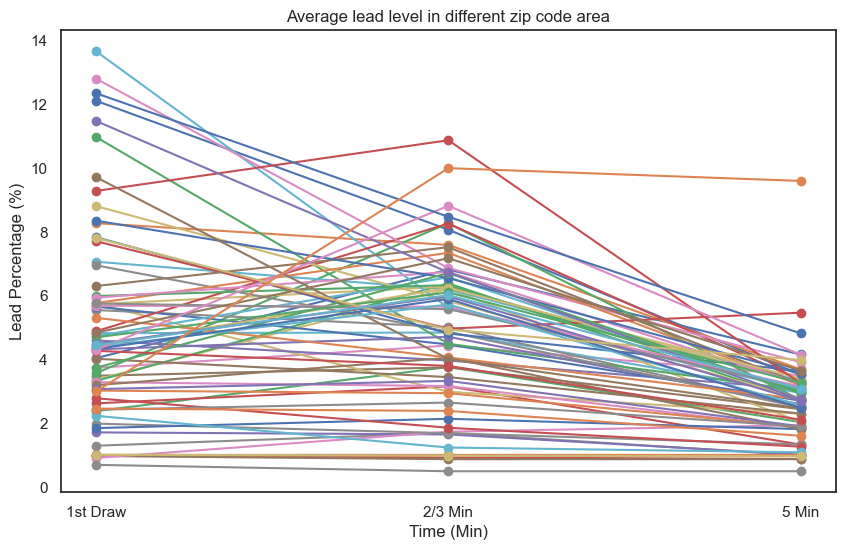

In [116]:
plt.figure(figsize=(10,6))

for i in range(72):
    plt.plot(['1st Draw', '2/3 Min', '5 Min'], averages.iloc[i, 1:], marker='o', label=averages.iloc[i, 0])

plt.xlabel('Time (Min)')
plt.ylabel('Lead Percentage (%)')
plt.title('Average lead level in different zip code area')

plt.show()

In [155]:
time_graph_df = merged_df[['Sample Date', '2/3 Min', 'zip']]

Q1 = time_graph_df['2/3 Min'].quantile(0.25)
Q3 = time_graph_df['2/3 Min'].quantile(0.75)
IQR = Q3 - Q1

filter = (time_graph_df['2/3 Min'] >= Q1 - 5 * IQR) & (time_graph_df['2/3 Min'] <= Q3 + 5 *IQR)
time_graph_df = time_graph_df.loc[filter]

time_graph_df['Year'] = time_graph_df['Sample Date'].dt.year
time_graph_df = time_graph_df.groupby(['Year', 'zip'])['2/3 Min'].mean().reset_index()


time_graph_df

,Year,zip,2/3 Min
0,2016,46320,2.700000
1,2016,60068,1.940000
2,2016,60302,3.044000
3,2016,60406,2.900000
4,2016,60453,4.328571
...,...,...,...
544,2023,60712,5.568421
545,2023,60714,7.266667
546,2023,60804,5.244444
547,2023,60805,5.440000


C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly condition

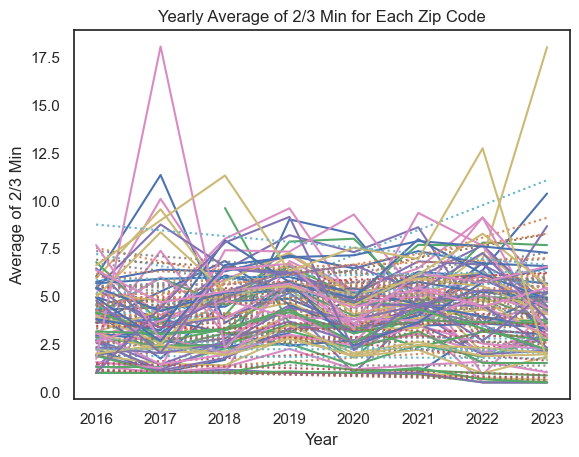

In [165]:
fig, ax = plt.subplots()
for name, group in time_graph_df.groupby('zip'):
    ax.plot(group['Year'], group['2/3 Min'],)
    z = np.polyfit(group['Year'], group['2/3 Min'], 1)
    p = np.poly1d(z)
    ax.plot(group['Year'], p(group['Year']),linestyle=':')
plt.legend().remove()
plt.title('Yearly Average of 2/3 Min for Each Zip Code')
plt.xlabel('Year')
plt.ylabel('Average of 2/3 Min')
plt.show()

C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\harry\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly condition

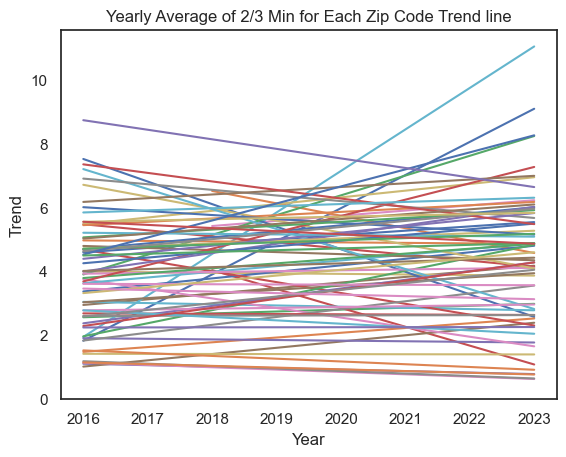

In [167]:
fig, ax = plt.subplots()
for name, group in time_graph_df.groupby('zip'):
    z = np.polyfit(group['Year'], group['2/3 Min'], 1)
    p = np.poly1d(z)
    ax.plot(group['Year'], p(group['Year']),)
plt.legend().remove()
plt.title('Yearly Average of 2/3 Min for Each Zip Code Trend line')
plt.xlabel('Year')
plt.ylabel('Trend')
plt.show()